<a href="https://colab.research.google.com/github/HusamAlzain/Plant-disease/blob/main/Palm_disease_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.io import imshow, imread, imsave
from skimage.transform import rotate, AffineTransform, warp,rescale, resize, downscale_local_mean
from skimage import color,data
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
import tensorflow as tf

#OpenCV-Python
import cv2

# imgaug
import imageio
import imgaug as ia
import imgaug.augmenters as iaa

# Albumentations
import albumentations as A

# Augmentor
!pip install augmentor
import Augmentor

# SOLT
!pip install solt
import solt
import solt.transforms as slt

#visualisation
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
from IPython.display import HTML, Image

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.17 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


  Preparing metadata (setup.py) ... done
  Created wheel for solt: filename=solt-0.1.9-py3-none-any.whl size=26366 sha256=e121f850ff0b055daf72e35b1931e8a2fba5dee32380324bc53f524f91735fde
  Stored in directory: /root/.cache/pip/wheels/1f/04/43/79bbcc6ff313329b07db7440e77e9a0bb0b61ccb5e4e840a42
Successfully built solt


In [ ]:
try:
  from fastai.vision.all import *
except ImportError:
  !pip install --upgrade fastai  # Use `!pip install` for notebook execution
  from fastai.vision.all import *

Keep the "New Plant Diseases Dataset" out of scope

# Modeling using Fast.AI

In [ ]:
from fastai.vision.all import *

# Define the path to your dataset
path2 = Path("/kaggle/working/palm-disease-dataset")
path3 = Path('/kaggle/input/diseases-of-date-palm-leaves-dataset/Processed/9. Healthy sample')

# Get all image files from both directories
image_data2 = get_image_files(path2)
image_data3 = get_image_files(path3)

# Merge the two lists of images
merged_image_data = image_data2 + image_data3  # Combine the two lists

# Define data augmentation
item_tfms = Resize(300)  # Resize images to 224x224 for input to the model
batch_tfms = aug_transforms(
    flip_vert=True,         # Flip vertically
    max_rotate=90,          # Rotate images by up to 90 degrees
    max_zoom=1.3,           # Zoom images
    max_lighting=0.3,       # Adjust lighting
    p_affine=0.75,          # Probability of applying affine transformations
    p_lighting=0.75,        # Probability of applying lighting adjustments
    max_warp=0.2,           # Apply warping
    do_flip=True,           # Flip images horizontally
    min_scale=0.8           # Minimum scale for zooming
)

Augmentation were so bad. Buildinig the model without it

# Data Loading

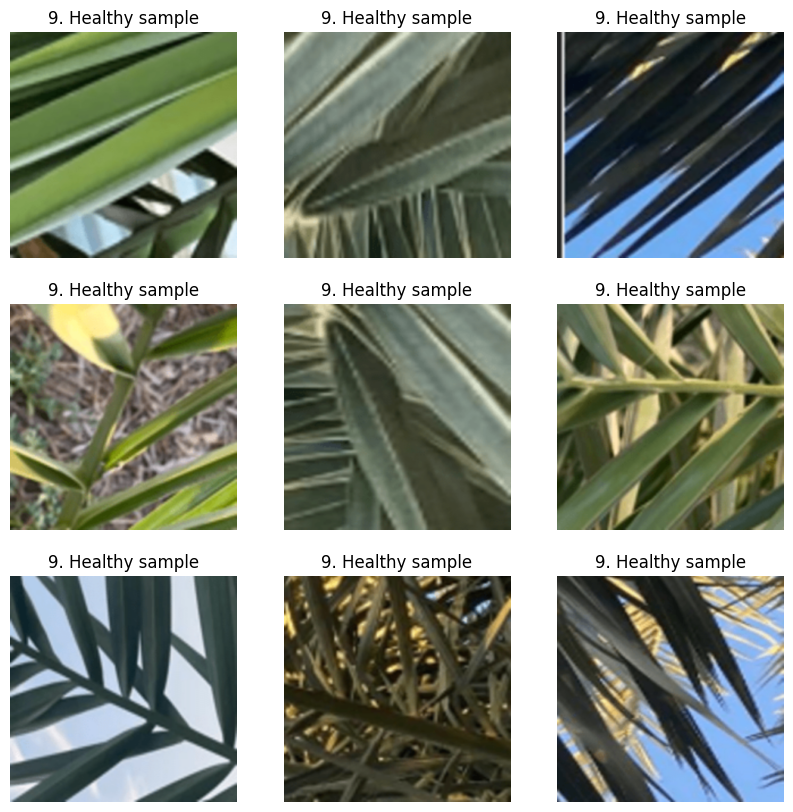

In [ ]:
# Adjusting the lambda function to accept the `source` parameter
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda x: merged_image_data,  # Use the merged image file list
    splitter=RandomSplitter(valid_pct=0.2, seed=42),  # Random 80-20 split for training and validation
    get_y=parent_label,  # Extracts the labels from the folder names
    item_tfms=item_tfms,  # Resize images to 224x224
#     batch_tfms=batch_tfms  # Apply data augmentation - It gave us bad results
)

# Create your DataLoaders with the merged images
dls = dblock.dataloaders(path2, bs=32, num_workers=0)  # Use path2 as the base path


In [ ]:
leaf=DataBlock(blocks=(ImageBlock,CategoryBlock),
               get_items=get_image_files,
               splitter=RandomSplitter(valid_pct=(0.2),seed=42),
               get_y=parent_label,item_tfms=Resize(300))

In [ ]:
dls=leaf.dataloaders(path,num_workers = 0,bs=32)

In [ ]:
#"`cnn_learner` has been renamed to `vision_learner` -- please update your code"
learner=vision_learner(dls,resnet50,metrics=[accuracy, error_rate])

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 171MB/s] 


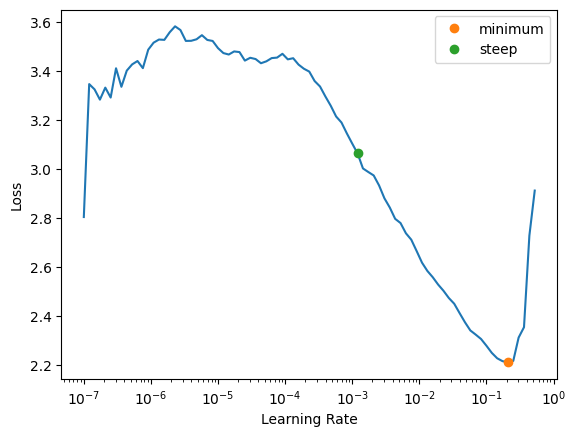

In [ ]:
lr_min,lr_steep = learner.lr_find(suggest_funcs=(minimum,steep))

In [ ]:
lr_steep

0.0012022644514217973

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.492487,0.580612,0.820097,0.179903,22:51


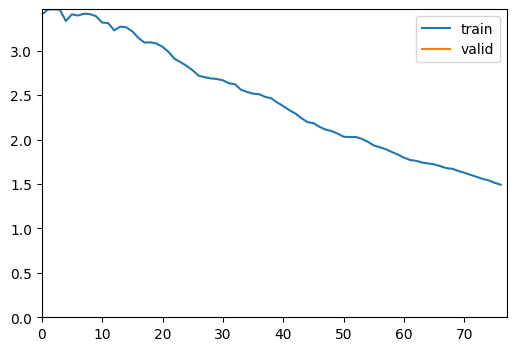

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.542374,0.363087,0.901135,0.098865,37:23
1,0.340686,0.296295,0.940032,0.059968,29:21
2,0.172552,0.234679,0.940032,0.059968,29:17
3,0.090392,0.224611,0.957861,0.042139,31:05


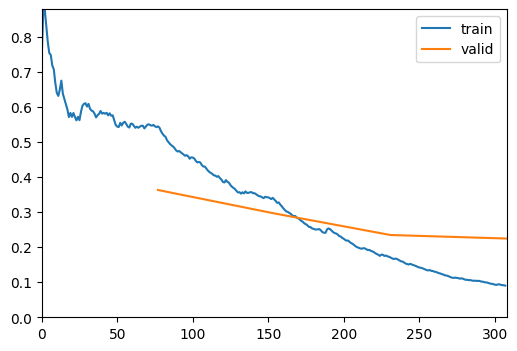

In [ ]:
learner.fine_tune(4,base_lr=lr_steep,cbs=[ShowGraphCallback()])

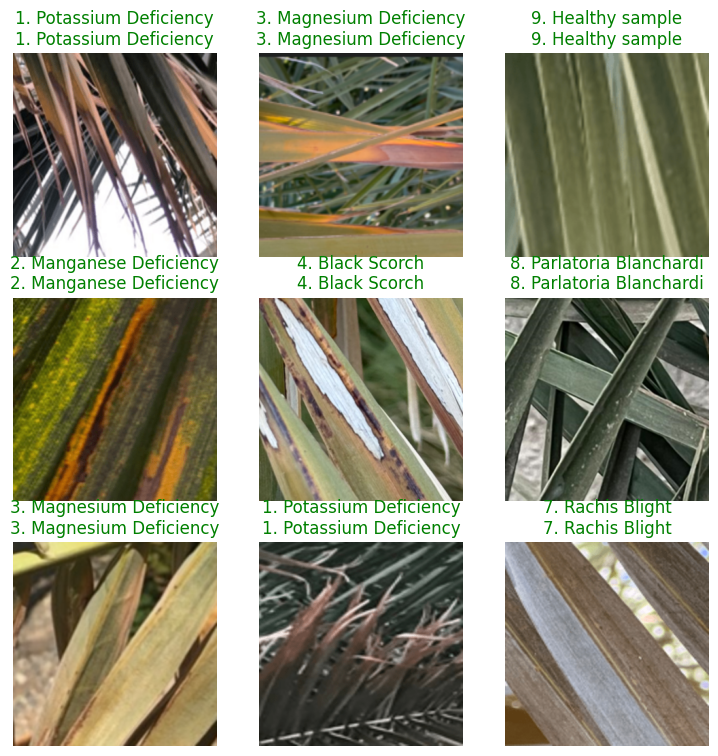

In [ ]:
learner.show_results()

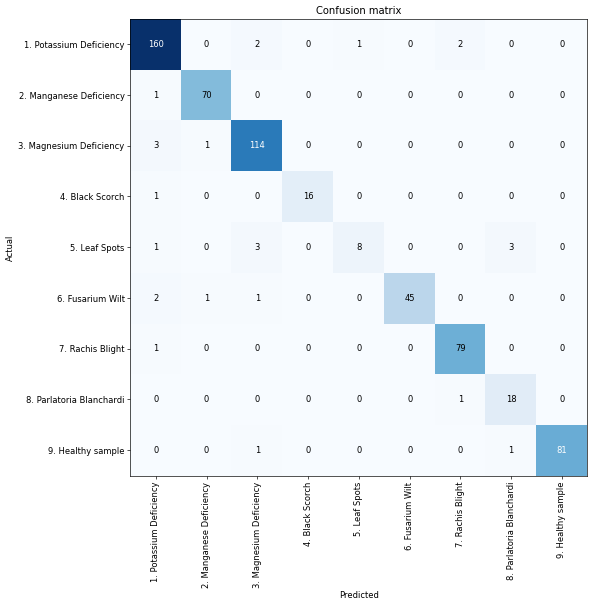

In [ ]:
from fastai.vision.all import ClassificationInterpretation

interp = ClassificationInterpretation.from_learner(learner)

interp.plot_confusion_matrix(figsize=(10,10), dpi=60)


In [ ]:
cm = interp.confusion_matrix()

# Calculate the per-class accuracy
per_class_accuracy = (cm.diagonal() / cm.sum(axis=1))

for i, class_name in enumerate(dls.vocab):
    print(f"Accuracy of class '{class_name}': {per_class_accuracy[i]*100:.2f}%")

Accuracy of class '1. Potassium Deficiency': 96.97%
Accuracy of class '2. Manganese Deficiency': 98.59%
Accuracy of class '3. Magnesium Deficiency': 96.61%
Accuracy of class '4. Black Scorch': 94.12%
Accuracy of class '5. Leaf Spots': 53.33%
Accuracy of class '6. Fusarium Wilt': 91.84%
Accuracy of class '7. Rachis Blight': 98.75%
Accuracy of class '8. Parlatoria Blanchardi': 94.74%
Accuracy of class '9. Healthy sample': 97.59%


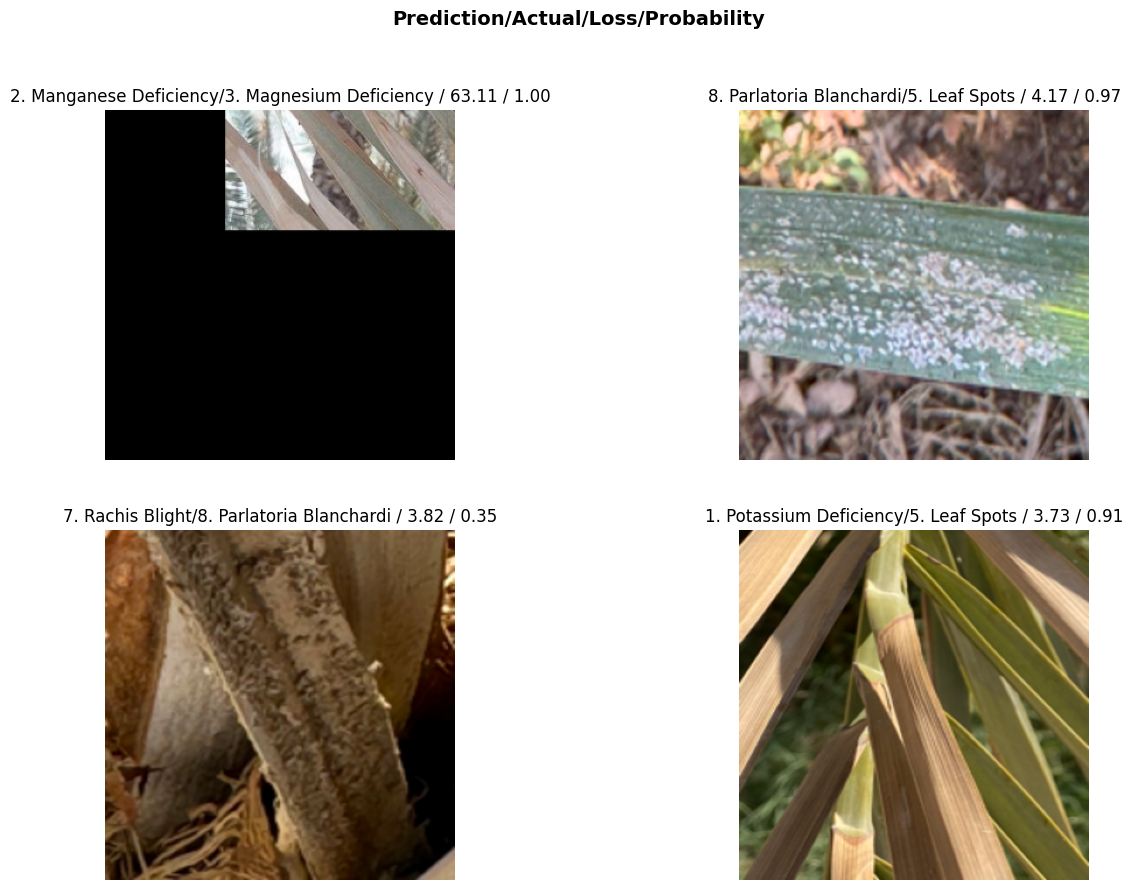

In [ ]:
interp.plot_top_losses(4, figsize=(15,10))

In [ ]:
learner.export('model_r50_5cls.pkl')

In [ ]:
learner.predict('/kaggle/input/diseases-of-date-palm-leaves-dataset/Processed/1. Potassium Deficiency/M9 (123).png')

('1. Potassium Deficiency',
 tensor(0),
 tensor([1.0000e+00, 3.6091e-07, 3.0313e-07, 5.4511e-07, 1.0284e-06, 7.7494e-07,
         4.2439e-07, 2.2571e-07, 1.6515e-08]))

In [ ]:
;